<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/1_3_1_1_Lab_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Classification

## Imports

In [1]:
!pip install ipympl

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Output
from matplotlib.widgets import Button, CheckButtons
from matplotlib.patches import FancyArrowPatch
import copy
import time
import math

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

## Functions and Classes

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

In [6]:
def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    """
    Computes the cost using  using matrices
    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameter(s) of the model
      b : (scalar )                       Values of parameter of the model
      verbose : (Boolean) If true, print out intermediate value f_wb
    Returns:
      total_cost: (scalar)                cost
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            z = X @ w + b                                                           #(m,n)(n,1)=(m,1)
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m                                                   # (scalar)
        else:
            f    = sigmoid(X @ w + b)                                               # (m,n)(n,1) = (m,1)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))   # (1,m)(m,1) = (1,1)
            cost = cost[0,0]                                                        # scalar
    else:
        f    = X @ w + b                                                        # (m,n)(n,1) = (m,1)
        cost = (1/(2*m)) * np.sum((f - y)**2)                                   # scalar

    reg_cost = (lambda_/(2*m)) * np.sum(w**2)                                   # scalar

    total_cost = cost + reg_cost                                                # scalar

    return total_cost                                                           # scalar

In [7]:
def compute_gradient_matrix(X, y, w, b, logistic=False, lambda_=0):
    """
    Computes the gradient using matrices

    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameters of the model
      b : (scalar )                       Values of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
    Returns
      dj_dw: (array_like Shape (n,1))     The gradient of the cost w.r.t. the parameters w
      dj_db: (scalar)                     The gradient of the cost w.r.t. the parameter b
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D

    f_wb  = sigmoid( X @ w + b ) if logistic else  X @ w + b      # (m,n)(n,1) = (m,1)
    err   = f_wb - y                                              # (m,1)
    dj_dw = (1/m) * (X.T @ err)                                   # (n,m)(m,1) = (n,1)
    dj_db = (1/m) * np.sum(err)                                   # scalar

    dj_dw += (lambda_/m) * w        # regularize                  # (n,1)

    return dj_db, dj_dw                                           # scalar, (n,1)

In [8]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters, logistic=False, lambda_=0, verbose=True):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray):    Shape (m,n)         matrix of examples
      y (ndarray):    Shape (m,) or (m,1) target value of each example
      w_in (ndarray): Shape (n,) or (n,1) Initial values of parameters of the model
      b_in (scalar):                      Initial value of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
      alpha (float):                      Learning rate
      num_iters (int):                    number of iterations to run gradient descent

    Returns:
      w (ndarray): Shape (n,) or (n,1)    Updated values of parameters; matches incoming shape
      b (scalar):                         Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    w = w.reshape(-1,1)      #prep for matrix operations
    y = y.reshape(-1,1)

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient_matrix(X, y, w, b, logistic, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_matrix(X, y, w, b, logistic, lambda_) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if verbose: print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w.reshape(w_in.shape), b, J_history  #return final w,b and J history for graphing

In [9]:
# for debug
#output = Output() # sends hidden error messages to display when using widgets
#display(output)

class plt_one_addpt_onclick:
    """ class to run one interactive plot """
    def __init__(self, x, y, w, b, logistic=True):
        self.logistic=logistic
        pos = y == 1
        neg = y == 0

        fig,ax = plt.subplots(1,1,figsize=(8,4))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False

        plt.subplots_adjust(bottom=0.25)
        ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
        ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors='dodgerblue',lw=3)
        ax.set_ylim(-0.05,1.1)
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0],xlim[1]*2)
        ax.set_ylabel('y')
        ax.set_xlabel('Tumor Size')
        self.alegend = ax.legend(loc='lower right')
        if self.logistic:
            ax.set_title("Example of Logistic Regression on Categorical Data")
        else:
            ax.set_title("Example of Linear Regression on Categorical Data")

        ax.text(0.65,0.8,"[Click to add data points]", size=10, transform=ax.transAxes)

        axcalc   = plt.axes([0.1, 0.05, 0.38, 0.075])  #l,b,w,h
        axthresh = plt.axes([0.5, 0.05, 0.38, 0.075])  #l,b,w,h
        self.tlist = []

        self.fig = fig
        self.ax = [ax,axcalc,axthresh]
        self.x = x
        self.y = y
        self.w = copy.deepcopy(w)
        self.b = b
        f_wb = np.matmul(self.x.reshape(-1,1), self.w) + self.b
        if self.logistic:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color='dodgerblue')
            self.bline = self.ax[0].plot(self.x, f_wb, color='orange',lw=1)
        else:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color='dodgerblue')

        self.cid = fig.canvas.mpl_connect('button_press_event', self.add_data)
        if self.logistic:
            self.bcalc = Button(axcalc, 'Run Logistic Regression (click)', color='dodgerblue')
            self.bcalc.on_clicked(self.calc_logistic)
        else:
            self.bcalc = Button(axcalc, 'Run Linear Regression (click)', color='dodgerblue')
            self.bcalc.on_clicked(self.calc_linear)
        self.bthresh = CheckButtons(axthresh, ('Toggle 0.5 threshold (after regression)',))
        self.bthresh.on_clicked(self.thresh)
        self.resize_sq(self.bthresh)

 #   @output.capture()  # debug
    def add_data(self, event):
        #self.ax[0].text(0.1,0.1, f"in onclick")
        if event.inaxes == self.ax[0]:
            x_coord = event.xdata
            y_coord = event.ydata

            if y_coord > 0.5:
                self.ax[0].scatter(x_coord, 1, marker='x', s=80, c = 'red' )
                self.y = np.append(self.y,1)
            else:
                self.ax[0].scatter(x_coord, 0, marker='o', s=100, facecolors='none', edgecolors='dodgerblue',lw=3)
                self.y = np.append(self.y,0)
            self.x = np.append(self.x,x_coord)
        self.fig.canvas.draw()

#   @output.capture()  # debug
    def calc_linear(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1,1,1,1,1,2,4,8,16,32,64,128,256]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.01, it,
                                                 logistic=False, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.alegend.remove()
            y_hat = np.matmul(self.x.reshape(-1,1), self.w) + self.b
            self.aline = self.ax[0].plot(self.x, y_hat, color='dodgerblue',
                                         label=f"y = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            self.draw_thresh()
            self.fig.canvas.draw()

    def calc_logistic(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1, 8,16,32,64,128,256,512,1024,2048,4096]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.1, it,
                                                 logistic=True, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.bline[0].remove()
            self.alegend.remove()
            xlim  = self.ax[0].get_xlim()
            x_hat = np.linspace(*xlim, 30)
            y_hat = sigmoid(np.matmul(x_hat.reshape(-1,1), self.w) + self.b)
            self.aline = self.ax[0].plot(x_hat, y_hat, color='dodgerblue',
                                         label="y = sigmoid(z)")
            f_wb = np.matmul(x_hat.reshape(-1,1), self.w) + self.b
            self.bline = self.ax[0].plot(x_hat, f_wb, color='orange', lw=1,
                                         label=f"z = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            self.draw_thresh()
            self.fig.canvas.draw()


    def thresh(self, event):
        if self.bthresh.get_status()[0]:
            #plt.figtext(0,0, f"in thresh {self.bthresh.get_status()}")
            self.draw_thresh()
        else:
            #plt.figtext(0,0.3, f"in thresh {self.bthresh.get_status()}")
            self.remove_thresh()

    def draw_thresh(self):
        ws = np.squeeze(self.w)
        xp5 = -self.b/ws if self.logistic else (0.5 - self.b) / ws
        ylim = self.ax[0].get_ylim()
        xlim = self.ax[0].get_xlim()
        a = self.ax[0].fill_between([xlim[0], xp5], [ylim[1], ylim[1]], alpha=0.2, color='dodgerblue')
        b = self.ax[0].fill_between([xp5, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color='darkred')
        c = self.ax[0].annotate("Malignant", xy= [xp5,0.5], xycoords='data',
             xytext=[30,5],textcoords='offset points')
        d = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5+1.5, 0.5), color='darkred',
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(d)

        e = self.ax[0].annotate("Benign", xy= [xp5,0.5], xycoords='data',
                     xytext=[-70,5],textcoords='offset points', ha='left')
        f = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5-1.5, 0.5), color='dodgerblue',
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(f)
        self.tlist = [a,b,c,d,e,f]

        self.fig.canvas.draw()

    def remove_thresh(self):
        #plt.figtext(0.5,0.0, f"rem thresh {self.bthresh.get_status()}")
        for artist in self.tlist:
            artist.remove()
        self.fig.canvas.draw()

    def resize_sq(self, bcid):
        """ resizes the check box """
        #future reference
        #print(f"width  : {bcid.rectangles[0].get_width()}")
        #print(f"height : {bcid.rectangles[0].get_height()}")
        #print(f"xy     : {bcid.rectangles[0].get_xy()}")
        #print(f"bb     : {bcid.rectangles[0].get_bbox()}")
        #print(f"points : {bcid.rectangles[0].get_bbox().get_points()}")  #[[xmin,ymin],[xmax,ymax]]

        h = bcid.rectangles[0].get_height()
        bcid.rectangles[0].set_height(3*h)

        ymax = bcid.rectangles[0].get_bbox().y1
        ymin = bcid.rectangles[0].get_bbox().y0

        bcid.lines[0][0].set_ydata([ymax,ymin])
        bcid.lines[0][1].set_ydata([ymin,ymax])

## Classification Problems

Examples of classification problems are things like: identifying email as Spam or Not Spam or determining if a tumor is malignant or benign. In particular, these are examples of *binary* classification where there are two possible outcomes.  Outcomes can be  described in pairs of 'positive'/'negative' such as 'yes'/'no, 'true'/'false' or '1'/'0'.

Plots of classification data sets often use symbols to indicate the outcome of an example. In the plots below, 'X' is used to represent the positive values while 'O' represents negative outcomes.

In [10]:
x_train = np.array([0, 1, 2, 3, 4, 5])
y_train = np.array([0, 0, 0, 1, 1, 1])
x_train, y_train

(array([0, 1, 2, 3, 4, 5]), array([0, 0, 0, 1, 1, 1]))

In [11]:
x_train2 = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train2 = np.array([0, 0, 0, 1, 1, 1])
x_train2, y_train2

(array([[0.5, 1.5],
        [1. , 1. ],
        [1.5, 0.5],
        [3. , 0.5],
        [2. , 2. ],
        [1. , 2.5]]),
 array([0, 0, 0, 1, 1, 1]))

In [12]:
pos = (y_train == 1)
neg = (y_train == 0)
pos, neg

(array([False, False, False,  True,  True,  True]),
 array([ True,  True,  True, False, False, False]))

In [13]:
pos2 = (y_train2 == 1)
neg2 = (y_train2 == 0)
pos2, neg2

(array([False, False, False,  True,  True,  True]),
 array([ True,  True,  True, False, False, False]))

In [14]:
x_train[pos], x_train[neg]

(array([3, 4, 5]), array([0, 1, 2]))

In [15]:
x_train2[neg, 0]

array([0.5, 1. , 1.5])

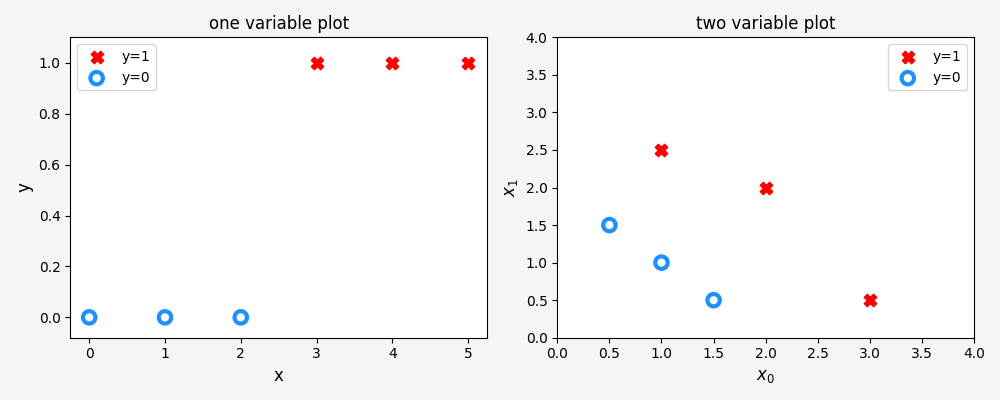

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.set_facecolor('whitesmoke')

# plot 1, single variable
ax[0].scatter(x_train[pos], y_train[pos],
              marker='X', s=80, c='red', label='y=1')
ax[0].scatter(x_train[neg], y_train[neg],
              marker='o', s=80, label='y=0', facecolors='none',
              edgecolor='dodgerblue', lw=3)
ax[0].set_ylim(-0.08, 1.1)
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('one variable plot')
ax[0].legend()

# plot 2, two variables
ax[1].scatter(x_train2[pos2, 0], x_train2[pos2, 1],
              marker='X', s=80, c='red', label='y=1')
ax[1].scatter(x_train2[neg2, 0], x_train2[neg2, 1],
              marker='o', s=80, label='y=0', facecolors='none',
              edgecolor='dodgerblue', lw=3)
ax[1].axis([0, 4, 0, 4])
ax[1].set_ylabel('$x_1$', fontsize=12)
ax[1].set_xlabel('$x_0$', fontsize=12)
ax[1].set_title('two variable plot')
ax[1].legend()

plt.tight_layout()
plt.show()

Notes about the plots above:

- In the single variable plot, positive results are shown both a red 'X's and as y=1. Negative results are blue 'O's and are located at y=0.
   - Recall in the case of linear regression, y would not have been limited to two values but could have been any value.
- In the two-variable plot, the y axis is not available.  Positive results are shown as red 'X's, while negative results use the blue 'O' symbol.
    - Recall in the case of linear regression with multiple variables, y would not have been limited to two values and a similar plot would have been three-dimensional.

## Linear Regression approach

In the previous week, you applied linear regression to build a prediction model. Let's try that approach here using the simple example that was described in the lecture. The model will predict if a tumor is benign or malignant based on tumor size.  Try the following:
- Click on 'Run Linear Regression' to find the best linear regression model for the given data.
    - Note the resulting linear model does **not** match the data well.
One option to improve the results is to apply a *threshold*.
- Tick the box on the 'Toggle 0.5 threshold' to show the predictions if a threshold is applied.
    - These predictions look good, the predictions match the data
- *Important*: Now, add further 'malignant' data points on the far right, in the large tumor size range (near 10), and re-run linear regression.
    - Now, the model predicts the larger tumor, but data point at x=3 is being incorrectly predicted!
- to clear/renew the plot, rerun the cell containing the plot command.

<ipython-input-9-980d0db11b54>:172: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  h = bcid.rectangles[0].get_height()
<ipython-input-9-980d0db11b54>:173: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  bcid.rectangles[0].set_height(3*h)
<ipython-input-9-980d0db11b54>:175: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  ymax = bcid.rectangles[0].get_bbox().y1
<ipython-input-9-980d0db11b54>:176: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  ymin = bcid.rectangles[0].get_bbox().

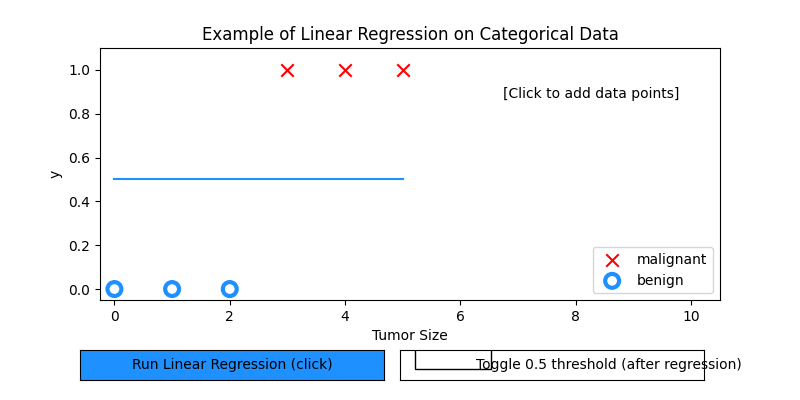

In [17]:
w_in = np.zeros((1))
b_in = 0
plt.close('all')
addpt = plt_one_addpt_onclick( x_train,y_train, w_in, b_in, logistic=False)

The example above demonstrates that the linear model is insufficient to model categorical data. The model can be extended as described in the following lab.